# Using VGG-16 as a base model for transfer learning

Now that I've trained a simple model using VGG-16 as a base, using only one Dense layer before output, I'd like to iterate on it to see how I can improve it. I'll be doing the same for InceptionV3 and comparing the two in order to make a final decision for my best model.

In [20]:
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from pickle import dump

from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [21]:
# Image folder for training
train_dir = 'input_images/full_combined'
val_dir = 'input_images/validation'

# Delete metadata files created by Mac OS
!find . -name ".DS_Store" -delete

In [22]:
# Make generators -- NOW USING SEPARATE VALIDATION SET/FOLDER (see split-folders.ipynb for details)
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=True,
                                   rotation_range=20, 
                                   brightness_range=[0.5, 1.5], 
                                   zoom_range=.2)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, class_mode='binary', shuffle=False)

Found 1619 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Instantiate base model

I'll use the VGG-16 model without its original Dense layers for feature extraction. I'll then add my own Dense layers and sigmoid activation output.

In [23]:
# Get base model
vgg_base_model = VGG16(weights='imagenet', 
                       include_top=False,
                       input_shape=(256, 256, 3))

# Freeze layers
for layer in vgg_base_model.layers:
    layer.trainable = False
    
# Check architecture
vgg_base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

## Iterations

Before, I simply added one Dense(512) layer on top of the base architecture. The original architecture of VGG-16 has 3 fully dense layers with 4096 nodes, generating predictions for 1000 classes w/Softmax activation. I'll be stepping that way down, plus only generating binary predictions with sigmoid activation.

I'll use `train_gen` and `val_gen` as defined above.

### Top with 2 Dense(512) layers 

In [24]:
# Instantiate model
vgg_1 = models.Sequential()

# Add base model
vgg_1.add(vgg_base_model)

# Flatten the output layer to 1 dimension
vgg_1.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation
vgg_1.add(Dense(512, activation='relu'))
vgg_1.add(Dense(512, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
vgg_1.add(Dense(1, activation='sigmoid'))

# Compile
vgg_1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [25]:
# Train the model
vgg_1_history = vgg_1.fit(train_gen,
                          epochs=20,
                          validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 305s 6s/step - loss: 1.0734 - acc: 0.7011 - recall: 0.7062 - precision: 0.7247 - val_loss: 0.2284 - val_acc: 0.8800 - val_recall: 0.8200 - val_precision: 0.9318
Epoch 2/20
51/51 [==============================] - 304s 6s/step - loss: 0.3532 - acc: 0.8456 - recall: 0.8165 - precision: 0.8843 - val_loss: 0.2859 - val_acc: 0.8500 - val_recall: 0.9200 - val_precision: 0.8070
Epoch 3/20
51/51 [==============================] - 300s 6s/step - loss: 0.3624 - acc: 0.8406 - recall: 0.8316 - precision: 0.8637 - val_loss: 0.2240 - val_acc: 0.9200 - val_recall: 0.9000 - val_precision: 0.9375
Epoch 4/20
51/51 [==============================] - 304s 6s/step - loss: 0.3197 - acc: 0.8641 - recall: 0.8467 - precision: 0.8923 - val_loss: 0.2349 - val_acc: 0.9200 - val_recall: 0.8800 - val_precision: 0.9565
Epoch 5/20
51/51 [==============================] - 312s 6s/step - loss: 0.3212 - acc: 0.8592 - recall: 0.8618 - precision: 0.8719 - val_loss: 0.215

In [26]:
vgg_1.save('models/vgg_1.h5')

Training eval:
51/51 [==============================] - 287s 6s/step - loss: 0.2027 - acc: 0.9172 - recall: 0.9721 - precision: 0.8838

Validation eval:
4/4 [==============================] - 11s 3s/step - loss: 0.1888 - acc: 0.9200 - recall: 0.9200 - precision: 0.9200


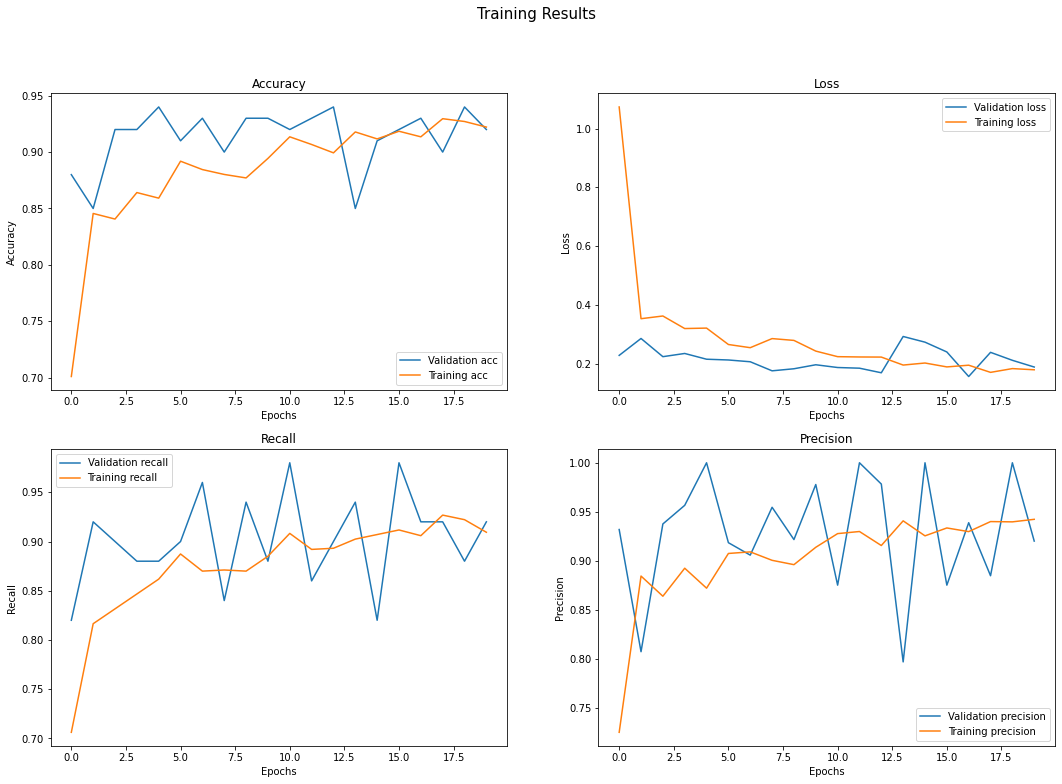

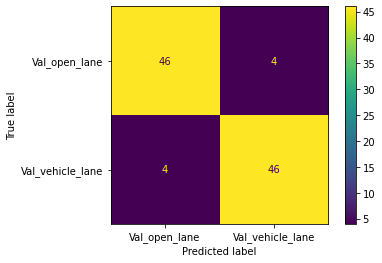

In [27]:
visualize_results(vgg_1_history, vgg_1, train_gen, val_gen)

In [28]:
dump(vgg_1_history.history, open('models/vgg_1_history.pkl', 'wb'))

Lowered the validation set for additional training after splitting validation into its own folders. No longer augmenting validation data! Also corrected a few mis-labeled images. 

So far this is still not fully beating cnn_model_4 on val metrics, but that model was likely way overfit and this one is far, far less so. That means it will likely do better on unseen data. The metrics here are very good though. VGG-16-based models seem very promising so far.

### 2 Dense layers and aggressive (0.5) Dropout to avoid overfitting

In [34]:
# Instantiate model
vgg_2 = models.Sequential()

# Add base model
vgg_2.add(vgg_base_model)

# Flatten the output layer to 1 dimension
vgg_2.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
vgg_2.add(Dense(512, activation='relu'))
vgg_2.add(Dropout(0.5))
vgg_2.add(Dense(512, activation='relu'))
vgg_2.add(Dropout(0.5))

# Add a final sigmoid layer with 1 node for classification output
vgg_2.add(Dense(1, activation='sigmoid'))

# Compile
vgg_2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [35]:
# Train the model
vgg_2_history = vgg_2.fit(train_gen,
                          epochs=20,
                          validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 425s 8s/step - loss: 1.3696 - acc: 0.6374 - recall: 0.6585 - precision: 0.6593 - val_loss: 0.3108 - val_acc: 0.8800 - val_recall: 0.9200 - val_precision: 0.8519
Epoch 2/20
51/51 [==============================] - 424s 8s/step - loss: 0.5042 - acc: 0.7542 - recall: 0.7712 - precision: 0.7676 - val_loss: 0.3326 - val_acc: 0.8900 - val_recall: 0.9800 - val_precision: 0.8305
Epoch 3/20
51/51 [==============================] - 428s 8s/step - loss: 0.4774 - acc: 0.7918 - recall: 0.7886 - precision: 0.8141 - val_loss: 0.3385 - val_acc: 0.8500 - val_recall: 0.8200 - val_precision: 0.8723
Epoch 4/20
51/51 [==============================] - 439s 9s/step - loss: 0.4936 - acc: 0.7591 - recall: 0.7062 - precision: 0.8161 - val_loss: 0.3165 - val_acc: 0.8900 - val_recall: 0.8800 - val_precision: 0.8980
Epoch 5/20
51/51 [==============================] - 438s 9s/step - loss: 0.4575 - acc: 0.7906 - recall: 0.7445 - precision: 0.8434 - val_loss: 0.339

In [36]:
vgg_2.save('models/vgg_2.h5')

Training eval:
51/51 [==============================] - 305s 6s/step - loss: 0.3434 - acc: 0.8833 - recall: 0.8049 - precision: 0.9706

Validation eval:
4/4 [==============================] - 12s 3s/step - loss: 0.2698 - acc: 0.9000 - recall: 0.8600 - precision: 0.9348


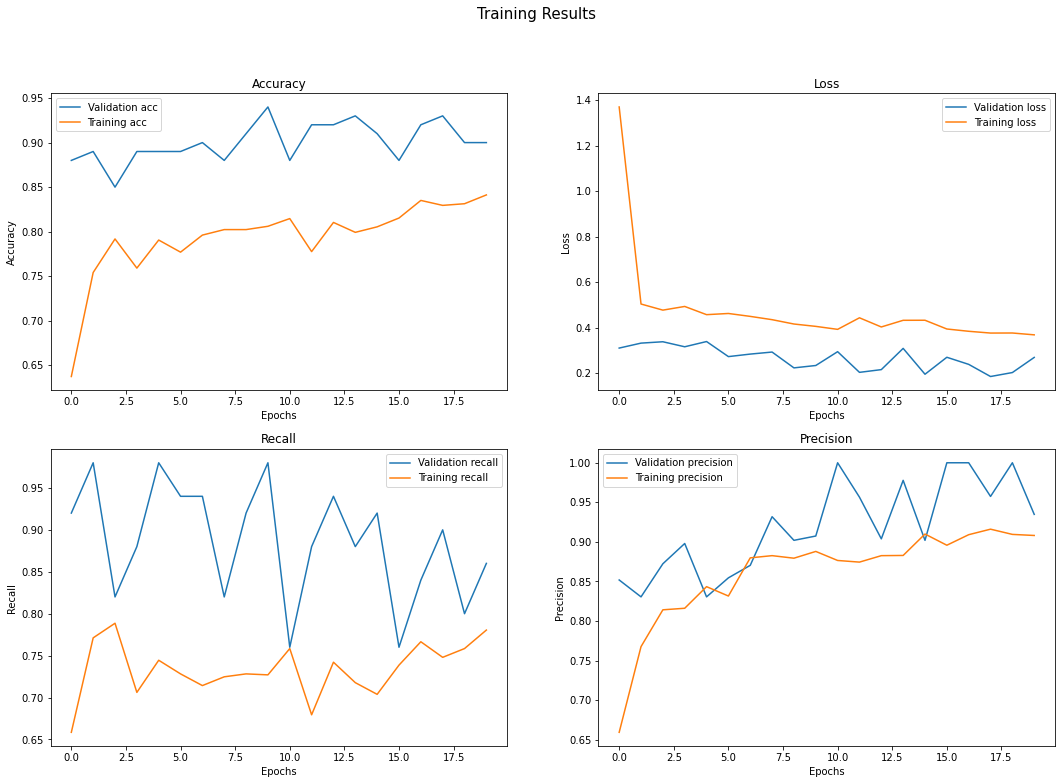

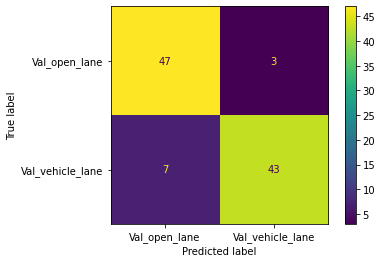

In [37]:
visualize_results(vgg_2_history, vgg_2, train_gen, val_gen)

In [38]:
dump(vgg_2_history.history, open('models/vgg_2_history.pkl', 'wb'))

A slight improvement on recall with the validation set. Interesting that the val metrics did not drop much but the training metrics did significantly, although that tracks with the goal of using dropout to reduce overfitting.

### More Dense layers with decreasing number of nodes

In [29]:
# Instantiate model
vgg_3 = models.Sequential()

# Add base model
vgg_3.add(vgg_base_model)

# Flatten the output layer to 1 dimension
vgg_3.add(Flatten())

# Add 2 fully connected layers with 512 hidden units and ReLU activation,
# plus Dropout layers
vgg_3.add(Dense(512, activation='relu'))
vgg_3.add(Dense(128, activation='relu'))
vgg_3.add(Dense(32, activation='relu'))

# Add a final sigmoid layer with 1 node for classification output
vgg_3.add(Dense(1, activation='sigmoid'))

# Compile
vgg_3.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc', 'Recall', 'Precision'])

In [30]:
# Train the model
vgg_3_history = vgg_3.fit(train_gen,
                          epochs=20,
                          validation_data=val_gen)

Epoch 1/20
51/51 [==============================] - 493s 10s/step - loss: 0.8861 - acc: 0.6973 - recall: 0.7166 - precision: 0.7149 - val_loss: 0.4384 - val_acc: 0.7700 - val_recall: 1.0000 - val_precision: 0.6849
Epoch 2/20
51/51 [==============================] - 448s 9s/step - loss: 0.3773 - acc: 0.8332 - recall: 0.8177 - precision: 0.8617 - val_loss: 0.3006 - val_acc: 0.8500 - val_recall: 0.9800 - val_precision: 0.7778
Epoch 3/20
51/51 [==============================] - 424s 8s/step - loss: 0.3536 - acc: 0.8530 - recall: 0.8583 - precision: 0.8643 - val_loss: 0.1889 - val_acc: 0.9400 - val_recall: 0.8800 - val_precision: 1.0000
Epoch 4/20
51/51 [==============================] - 423s 8s/step - loss: 0.3318 - acc: 0.8474 - recall: 0.8374 - precision: 0.8708 - val_loss: 0.4188 - val_acc: 0.8000 - val_recall: 0.9800 - val_precision: 0.7206
Epoch 5/20
51/51 [==============================] - 423s 8s/step - loss: 0.3205 - acc: 0.8678 - recall: 0.8664 - precision: 0.8828 - val_loss: 0.22

In [31]:
vgg_3.save('models/vgg_3.h5')

Training eval:
51/51 [==============================] - 299s 6s/step - loss: 0.1769 - acc: 0.9265 - recall: 0.8780 - precision: 0.9818

Validation eval:
4/4 [==============================] - 11s 3s/step - loss: 0.2338 - acc: 0.9400 - recall: 0.8800 - precision: 1.0000


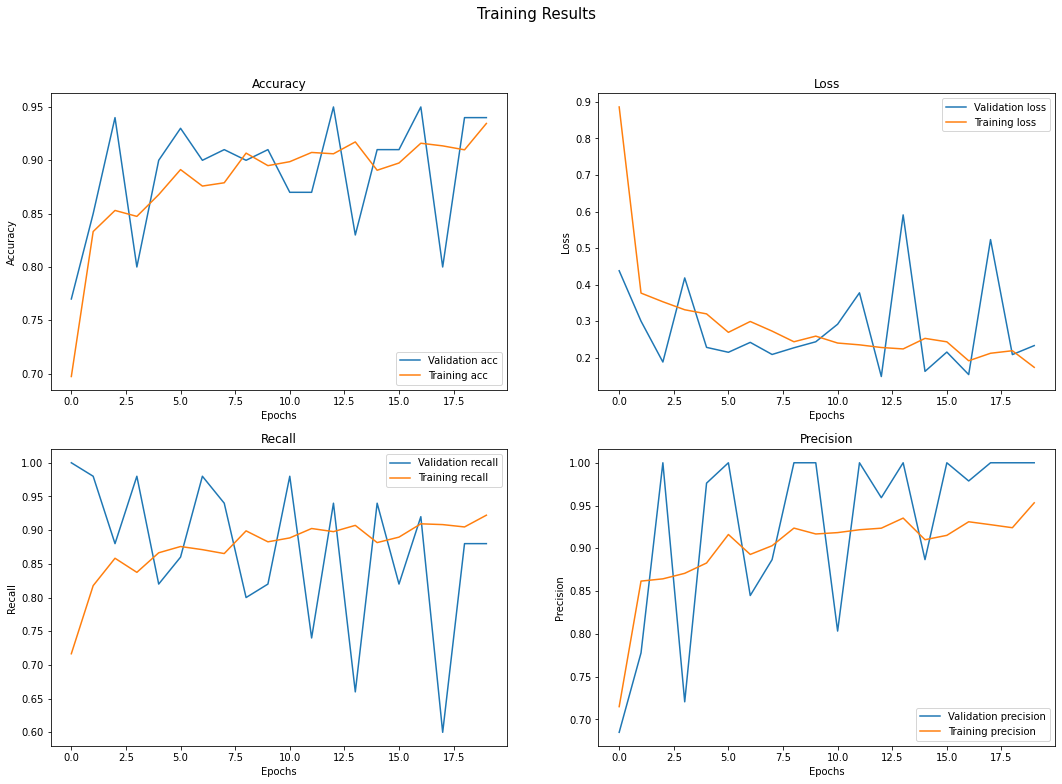

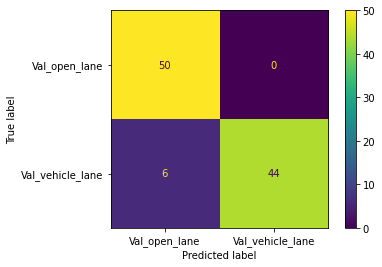

In [32]:
visualize_results(vgg_3_history, vgg_3, train_gen, val_gen)

In [33]:
dump(vgg_3_history.history, open('models/vgg_3_history.pkl', 'wb'))

The (unrealistically) high precision of this model reflects the high precision of the original vgg_transfer_model I tested before. Although recall is somewhat low, this is still an improvement over that prior model. If precision is truly more important than overall accuracy, it seems that a VGG-16-based model is the way to go here.


Predicted class: [0.]
Actual class: 0.0


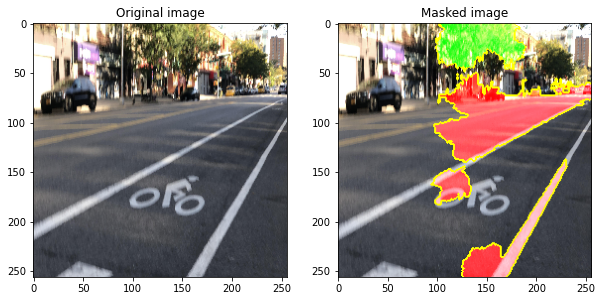

In [54]:
show_explanation(generator=val_gen, model=vgg_3)


Predicted class: [0.]
Actual class: 0.0


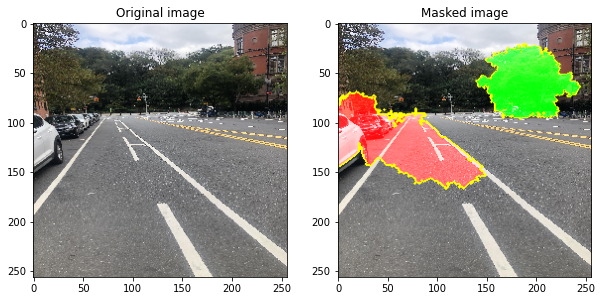

In [55]:
show_explanation(generator=val_gen, model=vgg_3)

I'm still getting bizarre results from Lime with these deeper pre-trained models. It looks like the colors are reversed or something. I'm going to try this from scratch instead of using my custom function to see if that takes care of it.

In [41]:
import lime
from lime import lime_image

In [42]:
datagen = ImageDataGenerator(rescale=1./255)
image_dir = 'input_images/validation'
img_gen = datagen.flow_from_directory(image_dir, class_mode='binary', shuffle=True, batch_size=1)

Found 100 images belonging to 2 classes.


Predicted class: [[0.]]
Actual class: [0.]


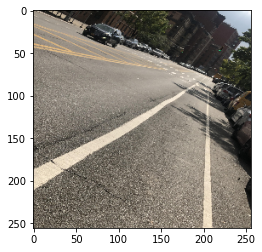

In [44]:
img, label = img_gen.next()
print('Predicted class:', np.round(vgg_3.predict(img)))
print('Actual class:', label)
plt.imshow(np.squeeze(img))

In [46]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.squeeze(img).astype('double'), vgg_3.predict)
image, mask = explanation.get_image_and_mask(vgg_3.predict(img).argmax(axis=1)[0], 
                                         positive_only=False, hide_rest=False)

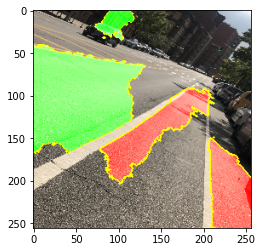

In [47]:
plt.imshow(mark_boundaries(image, mask))

Weird again...

Predicted class: [[1.]]
Actual class: [1.]


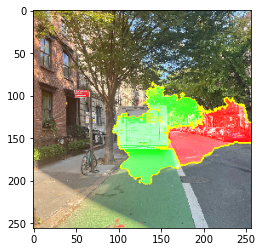

In [48]:
img, label = img_gen.next()
print('Predicted class:', np.round(vgg_3.predict(img)))
print('Actual class:', label)
plt.imshow(np.squeeze(img))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.squeeze(img).astype('double'), vgg_3.predict)
image, mask = explanation.get_image_and_mask(vgg_3.predict(img).argmax(axis=1)[0], 
                                         positive_only=False, hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

That's more like it. Maybe those were just flukes? This same thing happened the first time I tried Lime out on my CNNs--the first few images it spat out were very weird/unintuitive, but then it got better and much more consisten.


Predicted class: [0.]
Actual class: 0.0


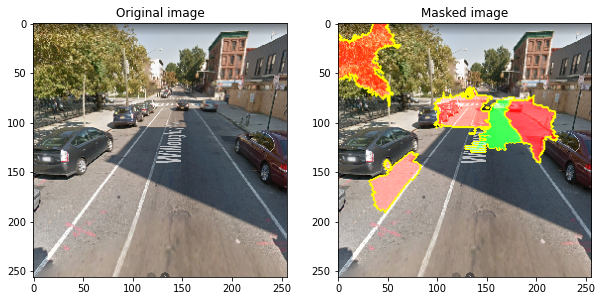

In [50]:
show_explanation(generator=img_gen, model=vgg_3)

Nope, still weird. Could it be my function that's giving it trouble? Try again from scratch:

Predicted class: [[0.]]
Actual class: [0.]


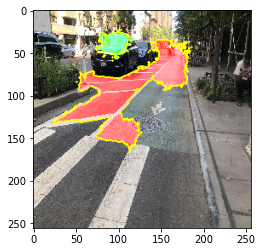

In [51]:
img, label = img_gen.next()
print('Predicted class:', np.round(vgg_3.predict(img)))
print('Actual class:', label)
plt.imshow(np.squeeze(img))

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.squeeze(img).astype('double'), vgg_3.predict)
image, mask = explanation.get_image_and_mask(vgg_3.predict(img).argmax(axis=1)[0], 
                                         positive_only=False, hide_rest=False)
plt.imshow(mark_boundaries(image, mask))


Predicted class: [0.]
Actual class: [0.]


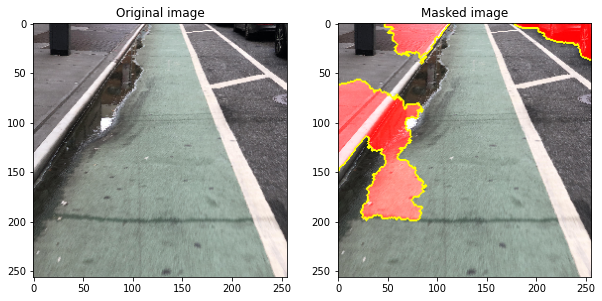

In [52]:
img, label = img_gen.next()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.squeeze(img).astype('double'), vgg_3.predict)
image, mask = explanation.get_image_and_mask(vgg_3.predict(img).argmax(axis=1)[0], 
                                         positive_only=False, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.set_title('Original image')
ax1.imshow(np.squeeze(img))

ax2.set_title('Masked image')
ax2.imshow(mark_boundaries(image, mask))

print('Predicted class:', np.round(vgg_3.predict(img))[0])
print('Actual class:', label)

plt.show()


Predicted class: [1.]
Actual class: 1.0


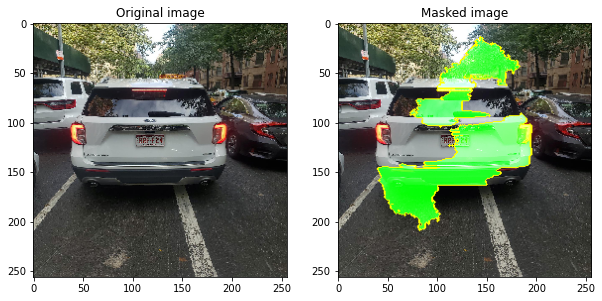

In [53]:
show_explanation(generator=val_gen, model=vgg_3)

That's better, but it's still *very* inconsistent. Is it something to do with the generator?


Predicted class: [1.]
Actual class: 1.0


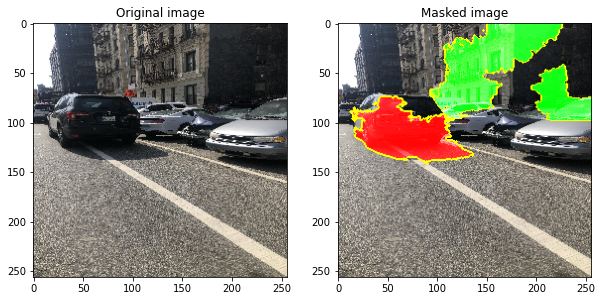

In [56]:
show_explanation(generator=val_gen, model=vgg_3)


Predicted class: [1.]
Actual class: 1.0


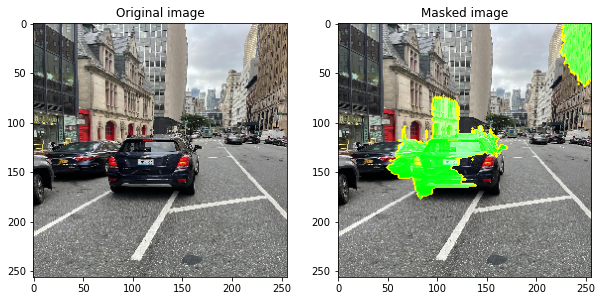

In [57]:
show_explanation(generator=img_gen, model=vgg_3)

In [ ]:
show_explanation(generator=img_gen, model=vgg_3)

In [ ]:
show_explanation(generator=img_gen, model=vgg_3)